## Three Stock Monte

This exercise tests your ability to retrieve stock price data using the Alpaca API and simulate multiple portfolio compositions using Monte Carlo Simulation.

### Import Dependencies

In [1]:
# Import libraries and dependencies
import os
import pandas as pd
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Get Past ~4 Year's Worth of Stock Price Data via Alpaca API Call

In [3]:
# Set timeframe to "1Day"
timeframe = "1Day"

# Set start and end datetimes between now and 4 years ago.
start_date = pd.Timestamp("2017-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-05-01", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["T","NKE","XOM"]

# Get 4 year's worth of historical price data
# HINT: Set "limit" to at least 10000 so all ticker rows are captured from get_bars()

df_ticker = api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df


# Display sample data
df_ticker.head()

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2017-05-01 04:00:00+00:00,55.40,55.45,54.98,54.99,4881442,30491,55.201737,NKE
2017-05-02 04:00:00+00:00,55.16,55.16,54.79,55.07,7363885,41589,54.967165,NKE
2017-05-03 04:00:00+00:00,55.17,55.30,54.40,54.53,9486619,48477,54.622933,NKE
2017-05-04 04:00:00+00:00,54.69,54.83,54.20,54.47,6830628,39260,54.501544,NKE
2017-05-05 04:00:00+00:00,54.49,54.50,53.56,53.95,13379949,57959,53.889567,NKE


> Note: We're going to simulate five years of growth below, and so we might want to pull at least five years of data in order to do that. But we pulled four because of Alpaca's rate limits--we can only pull 1,000 rows per ticker at a time (approximately four years of data, with 252 tradable days per year). If we pull data with repeated calls in a `for` loop, however, we can get quite a few more years than what we've got above.  

In [4]:
# Reorganize the DataFrame
# Separate ticker data
T = df_ticker[df_ticker["symbol"]=="T"].drop("symbol", axis=1)
NKE = df_ticker[df_ticker["symbol"]=="NKE"].drop("symbol", axis=1)
XOM = df_ticker[df_ticker["symbol"]=="XOM"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_ticker = pd.concat([T, NKE, XOM], axis=1, keys=["T","NKE","XOM"])

# Display sample data
df_ticker.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.69  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.15  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.38  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.06  38.71  38.03  38.56  21829853       82070   

                                        NKE                ...            \
                                vwap   open   high    low  ...    volume   
timestamp                                                  ...             
2017-05-01 04:00:00+00:00  39.278779  55.40  55.45  54.98  ...   4881442   
2017-05-02 04:00:00+00:00  38.996448  55.16  55.16  54.79  ...   7363885   
2017-05-03 04:00:00+00:00  38.423685  55.17  55.30  54.40  ...   9486619   
2017-05-04 04:00:00+00:00  37.965109  54.69  54.83  54.20  ...   6830628   
2017-05-05 04:00:00+00:00  38.424403  54.49  54.50  53.56  ...  13379949   

                                                    XOM                  \
                          trade_count       vwap   open     high    low   
timestamp                                                                 
2017-05-01 04:00:00+00:00       30491  55.201737  81.56  82.2100  81.48   
2017-05-02 04:00:00+00:00       41589  54.967165  82.17  82.5900  81.90   
2017-05-03 04:00:00+00:00       48477  54.622933  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00       39260  54.501544  82.28  82.3600  81.40   
2017-05-05 04:00:00+00:00       57959  53.889567  81.63  82.2350  81.61   

                                                                   
                           close    volume trade_count       vwap  
timestamp                                                          
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657  

[5 rows x 21 columns]

### Simulate five year portfolio growth with evenly-distributed stock investments

In [5]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
MC_even_dist = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.33,.33,.33],
    num_simulation = 1000,
    num_trading_days = 252*5
)

# Print the simulation input data
MC_even_dist.portfolio_data.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.69  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.15  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.38  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.06  38.71  38.03  38.56  21829853       82070   

                                                     NKE         ...  \
                                vwap daily_return   open   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.278779          NaN  55.40  55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836  55.16  55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121  55.17  55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156  54.69  54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470  54.49  54.50  ...   

                                                     XOM                  \
                                vwap daily_return   open     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.201737          NaN  81.56  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.967165     0.001455  82.17  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501544    -0.001100  82.28  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.889567    -0.009547  81.63  82.2350  81.61   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  

[5 rows x 24 columns]

In [6]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
MC_even_dist.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/hakobkeymetlyan/Rutgers/Fintech_Class/05-APIS/3/Activities/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001747,0.990106,1.016939,1.007867,1.022684,1.014459,1.008263,0.998881,0.991063,0.992351,...,0.988117,0.994342,1.017784,0.997106,0.994179,1.000433,0.993086,0.988509,1.008699,1.010244
2,1.005593,1.001592,1.031107,1.019919,1.018874,1.018808,0.998752,0.984290,0.999206,0.986462,...,0.986596,0.989635,1.016872,1.006759,0.988411,1.015939,0.986500,0.982045,1.003140,1.018955
3,1.000044,1.001443,1.038697,1.031173,1.033675,1.005930,1.001676,0.961156,0.996779,0.984740,...,0.986620,0.980757,1.021048,1.005144,0.989484,0.996150,0.988683,0.980318,0.998637,1.004224
4,1.007492,0.991299,1.048952,1.017375,1.049336,0.999614,1.005013,0.952804,1.006477,0.974824,...,0.988654,0.983717,1.009230,0.986990,1.004643,0.997134,0.977565,0.979333,1.001160,0.996709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.588203,1.712074,1.243063,0.675412,1.380544,1.644151,1.258669,0.780812,1.691217,0.656919,...,1.050160,1.978660,0.796414,0.850162,1.815637,1.382432,1.978731,1.087751,1.154363,1.706993
1257,1.561558,1.689151,1.241868,0.671417,1.377641,1.633249,1.272899,0.784090,1.675659,0.657974,...,1.041568,1.989457,0.785386,0.850103,1.798649,1.378559,1.954769,1.095259,1.164307,1.685242
1258,1.547610,1.688580,1.244334,0.665072,1.371270,1.620451,1.263446,0.775160,1.697928,0.667134,...,1.023802,1.974091,0.781349,0.840633,1.813789,1.387841,1.942262,1.100786,1.170806,1.690805
1259,1.546511,1.699791,1.266085,0.651737,1.354752,1.612852,1.258912,0.778859,1.672584,0.667256,...,1.013372,1.982875,0.784472,0.843902,1.836076,1.401128,1.960665,1.108762,1.167084,1.708698


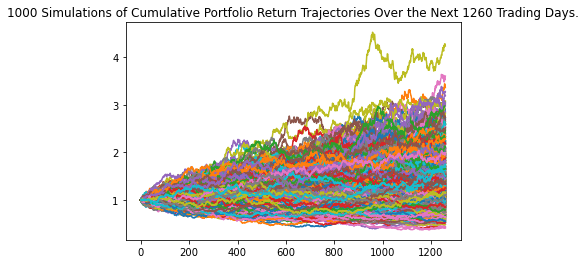

In [7]:
# Plot simulation outcomes
line_plot = MC_even_dist.plot_simulation()

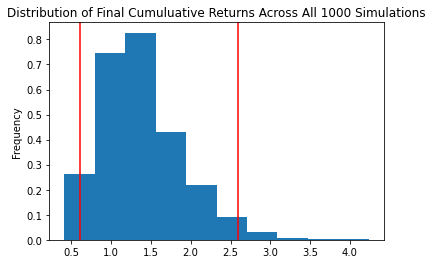

In [8]:
# Plot probability distribution and confidence intervals
dist_plot = MC_even_dist.plot_distribution()

In [9]:
# Fetch summary statistics from the Monte Carlo simulation results

even_tbl = MC_even_dist.summarize_cumulative_return()
# Print summary statistics
print(even_tbl)

count           1000.000000
mean               1.384662
std                0.511752
min                0.412374
25%                1.036081
50%                1.299553
75%                1.657714
max                4.234820
95% CI Lower       0.605906
95% CI Upper       2.592578
Name: 1260, dtype: float64


In [11]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
even_ci_lower = round(even_tbl[8]*15000,2)
even_ci_upper = round(even_tbl[9]*15000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${even_ci_lower} and ${even_ci_upper}.")

There is a 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end within in the range of $9088.59 and $38888.68.


### Simulate five year portfolio growth with 60% AT&T stock

In [14]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_att = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.20,.60,.20],
    num_simulation = 1000,
    num_trading_days = 252*5
)
# Print the simulation input data
MC_att.portfolio_data.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.69  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.15  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.38  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.06  38.71  38.03  38.56  21829853       82070   

                                                     NKE         ...  \
                                vwap daily_return   open   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.278779          NaN  55.40  55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836  55.16  55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121  55.17  55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156  54.69  54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470  54.49  54.50  ...   

                                                     XOM                  \
                                vwap daily_return   open     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.201737          NaN  81.56  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.967165     0.001455  82.17  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501544    -0.001100  82.28  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.889567    -0.009547  81.63  82.2350  81.61   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  

[5 rows x 24 columns]

In [15]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_att.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/hakobkeymetlyan/Rutgers/Fintech_Class/05-APIS/3/Activities/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003868,0.982284,1.010717,0.988938,0.996583,1.030036,1.013355,1.013836,1.001156,0.989555,...,1.020146,1.001381,0.982855,0.983985,1.008577,0.993206,1.013140,1.014248,1.004565,1.008623
2,0.997391,0.981636,0.968847,0.992507,0.989103,1.023922,1.020535,1.012761,0.981048,0.976921,...,1.040888,1.000120,0.966328,0.978146,1.012831,0.983058,1.000254,1.008162,1.008644,1.024695
3,0.993626,0.972730,0.964922,0.989782,0.998454,1.025083,1.040844,1.005688,0.951002,0.987211,...,1.051931,1.016085,0.962285,0.993288,0.999022,0.989078,0.996086,1.013978,0.989665,1.013932
4,0.962761,0.983533,0.945089,0.999915,1.004489,1.005836,1.062701,0.974662,0.965161,0.977712,...,1.051285,1.030180,0.945028,1.002647,0.981315,1.008856,1.024265,1.025347,0.995610,1.024177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,3.584356,1.591506,2.131207,3.550776,1.596328,1.600283,1.702203,1.610331,1.679344,4.136220,...,2.826024,1.663069,1.958085,2.851056,2.786765,2.647688,1.466282,1.310075,1.497011,2.453326
1257,3.630778,1.609854,2.075149,3.493051,1.594045,1.603333,1.716635,1.620575,1.698032,4.038305,...,2.795344,1.649430,1.926256,2.828341,2.776914,2.682546,1.470293,1.289977,1.502592,2.429959
1258,3.561255,1.618528,2.076634,3.533241,1.604402,1.599406,1.742005,1.621583,1.701251,4.046044,...,2.834315,1.682182,1.903701,2.874698,2.781427,2.682417,1.471923,1.281618,1.504079,2.437007
1259,3.605881,1.603830,2.049483,3.578490,1.606584,1.591117,1.741691,1.586194,1.714564,4.016978,...,2.772201,1.678333,1.876406,2.893577,2.786009,2.698970,1.474245,1.270817,1.519771,2.474696


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

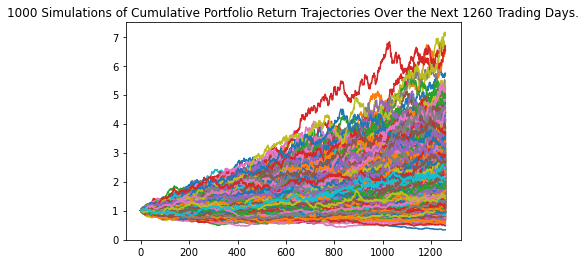

In [20]:
# Plot simulation outcomes
att_line_plot = MC_att.plot_simulation()
att_line_plot

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 1000 Simulations'}, ylabel='Frequency'>

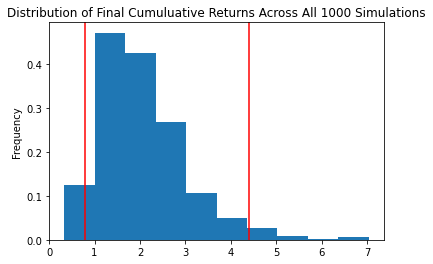

In [22]:
# Plot probability distribution and confidence intervals
att_dist_plot = MC_att.plot_distribution()
att_dist_plot

In [24]:
# Fetch summary statistics from the Monte Carlo simulation results
att_tbl = MC_att.summarize_cumulative_return()

# Print summary statistics
att_tbl

count           1000.000000
mean               2.073091
std                0.951232
min                0.334826
25%                1.406711
50%                1.883509
75%                2.549557
max                7.033239
95% CI Lower       0.780429
95% CI Upper       4.408601
Name: 1260, dtype: float64

In [26]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
att_ci_lower = round(att_tbl[8]*15000, 2)
att_ci_upper = round(att_tbl[9]*15000,2)
# Print results
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${att_ci_lower} and ${att_ci_upper}.")

There is a 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end within in the range of $11706.44 and $66129.01.


### Simulate five year portfolio growth with 60% Nike stock

In [29]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
MC_nike = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.60,.20,.20],
    num_simulation = 1000,
    num_trading_days = 252*5
)

# Printing the simulation input data
MC_nike.portfolio_data

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.69  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.15  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.38  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.06  38.71  38.03  38.56  21829853       82070   
...                          ...    ...    ...    ...       ...         ...   
2021-04-26 04:00:00+00:00  31.37  31.38  30.89  30.91  45361484      135224   
2021-04-27 04:00:00+00:00  30.80  30.88  30.63  30.77  33200289      123037   
2021-04-28 04:00:00+00:00  31.00  31.15  30.90  30.96  27960386      105457   
2021-04-29 04:00:00+00:00  31.14  31.53  31.11  31.34  37759889      129299   
2021-04-30 04:00:00+00:00  31.41  31.43  31.05  31.41  31132763      103027   

                                                      NKE          ...  \
                                vwap daily_return    open    high  ...   
timestamp                                                          ...   
2017-05-01 04:00:00+00:00  39.278779          NaN   55.40   55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836   55.16   55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121   55.17   55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156   54.69   54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470   54.49   54.50  ...   
...                              ...          ...     ...     ...  ...   
2021-04-26 04:00:00+00:00  31.027616    -0.015605  130.49  131.70  ...   
2021-04-27 04:00:00+00:00  30.742178    -0.004529  132.00  132.79  ...   
2021-04-28 04:00:00+00:00  31.009157     0.006175  132.51  132.29  ...   
2021-04-29 04:00:00+00:00  31.320010     0.012274  131.77  134.12  ...   
2021-04-30 04:00:00+00:00  31.287630     0.002234  132.44  133.88  ...   

                                                      XOM                  \
                                 vwap daily_return   open     high    low   
timestamp                                                                   
2017-05-01 04:00:00+00:00   55.201737          NaN  81.56  82.2100  81.48   
2017-05-02 04:00:00+00:00   54.967165     0.001455  82.17  82.5900  81.90   
2017-05-03 04:00:00+00:00   54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00   54.501544    -0.001100  82.28  82.3600  81.40   
2017-05-05 04:00:00+00:00   53.889567    -0.009547  81.63  82.2350  81.61   
...                               ...          ...    ...      ...    ...   
2021-04-26 04:00:00+00:00  130.887296     0.010830  55.54  56.2850  55.44   
2021-04-27 04:00:00+00:00  132.161201     0.003875  55.98  56.6300  55.81   
2021-04-28 04:00:00+00:00  130.802962    -0.010597  56.86  58.4600  56.79   
2021-04-29 04:00:00+00:00  132.969621     0.019509  58.90  59.4800  58.15   
2021-04-30 04:00:00+00:00  132.817825    -0.004803  58.24  58.8900  57.16   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  
...                          ...       ...         ...        ...          ...  
2021-04-26 04:00:00+00:00  55.68  16034118       92922  55.853625     0.001979 

In [31]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
MC_nike.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/hakobkeymetlyan/Rutgers/Fintech_Class/05-APIS/3/Activities/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.996924,1.006798,1.013629,0.994973,0.980152,0.989515,1.012936,1.008937,0.996312,1.017746,...,0.983378,1.002518,0.999417,0.993388,0.989161,0.993200,0.996674,0.999578,0.994635,0.981400
2,0.991218,1.001392,1.032446,0.997375,0.980799,0.985666,1.030323,1.006596,0.986377,1.034561,...,1.000452,0.999866,1.004627,1.004867,0.991005,0.979687,0.994489,1.013252,1.010752,0.980696
3,0.995005,0.985661,1.049420,1.008515,0.991711,0.987946,1.043338,0.991915,0.987718,1.046157,...,0.996642,1.003700,0.988006,1.024931,0.969812,0.963425,1.005059,1.001539,0.995919,0.993298
4,0.998911,0.977885,1.051157,1.005877,0.995235,0.978016,1.040225,0.993375,0.983276,1.049502,...,1.001586,1.022586,0.987818,1.029043,0.956332,0.968805,1.008283,1.018168,0.990851,0.977279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.127329,0.555884,0.391223,0.681389,1.452834,1.972365,1.793955,0.808966,1.078118,1.614642,...,0.993341,1.951966,1.268073,0.796067,0.522297,1.136101,0.597424,0.900565,1.447931,0.708289
1257,1.107237,0.547592,0.386461,0.675491,1.450234,1.982273,1.804357,0.807549,1.080745,1.612918,...,0.994830,1.939638,1.255890,0.799758,0.526409,1.130173,0.583973,0.902410,1.423898,0.708978
1258,1.117064,0.544178,0.385481,0.668107,1.470576,1.969351,1.824588,0.808747,1.066151,1.610373,...,1.017492,1.943486,1.264021,0.804803,0.520200,1.129026,0.585106,0.906441,1.430868,0.704217
1259,1.123539,0.559814,0.384710,0.662898,1.438830,1.949484,1.855571,0.806182,1.078004,1.625663,...,1.030071,1.964849,1.297107,0.816519,0.529582,1.143923,0.577088,0.897155,1.429187,0.706807


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

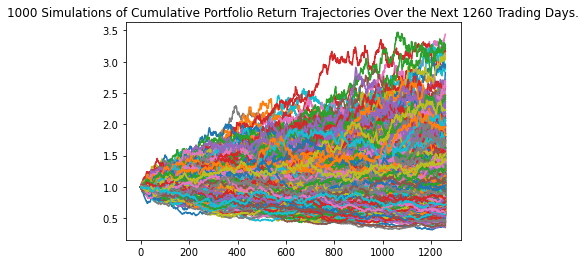

In [32]:
# Plot simulation outcomes
MC_nike.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 1000 Simulations'}, ylabel='Frequency'>

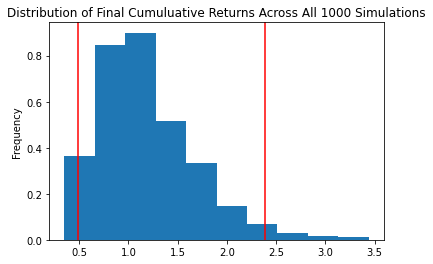

In [33]:
# Plot probability distribution and confidence intervals
MC_nike.plot_distribution()

In [35]:
# Fetch summary statistics from the Monte Carlo simulation results
nike_tbl = MC_nike.summarize_cumulative_return()

# Print summary statistics
nike_tbl

count           1000.000000
mean               1.185109
std                0.489730
min                0.348846
25%                0.836944
50%                1.094049
75%                1.452468
max                3.439013
95% CI Lower       0.490526
95% CI Upper       2.390728
Name: 1260, dtype: float64

In [37]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
nike_ci_lower = round(nike_tbl[8]*15000, 2)
nike_ci_upper = round(nike_tbl[9]*15000, 2)

# Print results
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${nike_ci_lower} and ${nike_ci_upper}.")

There is a 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end within in the range of $7357.9 and $35860.92.


### Simulate five year portfolio growth with 60% Exxon stock

In [38]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
MC_exxon = MCSimulation(
    portfolio_data=df_ticker,
    weights=[.20,.20,.60],
    num_simulation=1000,
    num_trading_days=252*5
)

# Printing the simulation input data
MC_exxon.portfolio_data

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.69  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.15  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.38  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.06  38.71  38.03  38.56  21829853       82070   
...                          ...    ...    ...    ...       ...         ...   
2021-04-26 04:00:00+00:00  31.37  31.38  30.89  30.91  45361484      135224   
2021-04-27 04:00:00+00:00  30.80  30.88  30.63  30.77  33200289      123037   
2021-04-28 04:00:00+00:00  31.00  31.15  30.90  30.96  27960386      105457   
2021-04-29 04:00:00+00:00  31.14  31.53  31.11  31.34  37759889      129299   
2021-04-30 04:00:00+00:00  31.41  31.43  31.05  31.41  31132763      103027   

                                                      NKE          ...  \
                                vwap daily_return    open    high  ...   
timestamp                                                          ...   
2017-05-01 04:00:00+00:00  39.278779          NaN   55.40   55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836   55.16   55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121   55.17   55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156   54.69   54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470   54.49   54.50  ...   
...                              ...          ...     ...     ...  ...   
2021-04-26 04:00:00+00:00  31.027616    -0.015605  130.49  131.70  ...   
2021-04-27 04:00:00+00:00  30.742178    -0.004529  132.00  132.79  ...   
2021-04-28 04:00:00+00:00  31.009157     0.006175  132.51  132.29  ...   
2021-04-29 04:00:00+00:00  31.320010     0.012274  131.77  134.12  ...   
2021-04-30 04:00:00+00:00  31.287630     0.002234  132.44  133.88  ...   

                                                      XOM                  \
                                 vwap daily_return   open     high    low   
timestamp                                                                   
2017-05-01 04:00:00+00:00   55.201737          NaN  81.56  82.2100  81.48   
2017-05-02 04:00:00+00:00   54.967165     0.001455  82.17  82.5900  81.90   
2017-05-03 04:00:00+00:00   54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00   54.501544    -0.001100  82.28  82.3600  81.40   
2017-05-05 04:00:00+00:00   53.889567    -0.009547  81.63  82.2350  81.61   
...                               ...          ...    ...      ...    ...   
2021-04-26 04:00:00+00:00  130.887296     0.010830  55.54  56.2850  55.44   
2021-04-27 04:00:00+00:00  132.161201     0.003875  55.98  56.6300  55.81   
2021-04-28 04:00:00+00:00  130.802962    -0.010597  56.86  58.4600  56.79   
2021-04-29 04:00:00+00:00  132.969621     0.019509  58.90  59.4800  58.15   
2021-04-30 04:00:00+00:00  132.817825    -0.004803  58.24  58.8900  57.16   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  
...                          ...       ...         ...        ...          ...  
2021-04-26 04:00:00+00:00  55.68  16034118       92922  55.853625     0.001979 

In [39]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
MC_exxon.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/hakobkeymetlyan/Rutgers/Fintech_Class/05-APIS/3/Activities/04-Stu_Three_Stock_Monte/Unsolved/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.999209,1.008194,1.009625,0.999279,1.019063,0.974794,0.992437,1.014196,0.975972,0.986884,...,1.014220,1.006256,0.973354,0.979842,1.007458,1.002884,0.992448,0.993447,0.985823,0.985697
2,1.006437,1.023020,1.007453,0.986640,1.028470,0.979803,0.968048,1.011929,0.960859,1.003698,...,1.008394,0.962797,0.959499,0.961522,1.002384,1.005006,0.976677,1.001852,0.984304,0.967376
3,1.011835,1.013162,0.989814,0.988338,1.041724,0.958171,0.967792,0.995373,0.955551,1.013709,...,0.998894,0.977581,0.963312,0.966738,0.990718,0.994108,0.976613,1.012525,0.999140,0.945012
4,1.013112,0.999031,0.997833,0.965950,1.036755,0.961564,0.955291,0.990707,0.947097,0.992383,...,1.016793,0.967459,0.980193,0.965606,0.990817,0.982596,0.968798,1.023038,0.996482,0.960612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.335154,0.961505,0.439295,0.761475,0.994616,0.456992,2.795450,1.428605,0.856476,1.858325,...,0.986578,0.744197,0.516390,1.426546,1.037180,1.409637,0.883714,1.566595,0.923696,1.343944
1257,1.346337,0.968963,0.453108,0.762141,0.978596,0.448454,2.709567,1.439483,0.857749,1.832654,...,0.979721,0.730980,0.515254,1.416823,1.011113,1.424021,0.877993,1.588076,0.932901,1.352754
1258,1.382724,0.952152,0.459449,0.765080,0.980225,0.445336,2.734557,1.439544,0.847083,1.854954,...,0.985502,0.726522,0.519311,1.391831,1.006424,1.430395,0.877497,1.592938,0.917574,1.362878
1259,1.412368,0.964652,0.457033,0.755855,0.978468,0.444121,2.735896,1.437962,0.839478,1.842408,...,0.981874,0.732371,0.521189,1.414475,0.988672,1.424409,0.879357,1.640287,0.937635,1.341763


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

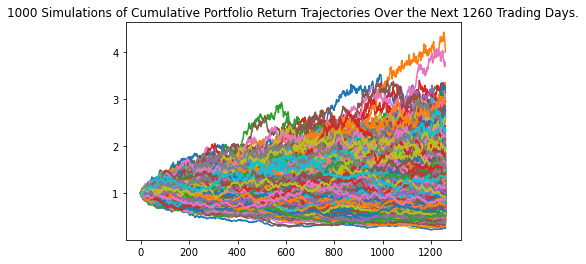

In [40]:
# Plot simulation outcomes
MC_exxon.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 1000 Simulations'}, ylabel='Frequency'>

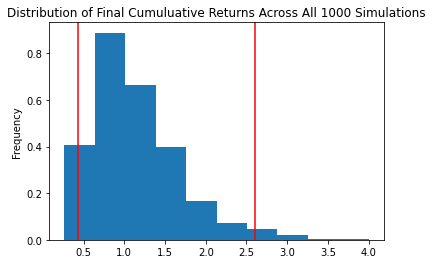

In [41]:
# Plot probability distribution and confidence intervals
MC_exxon.plot_distribution()

In [42]:
# Fetch summary statistics from the Monte Carlo simulation results
exxon_tbl = MC_exxon.summarize_cumulative_return()

# Print summary statistics
exxon_tbl

count           1000.000000
mean               1.145634
std                0.540307
min                0.263125
25%                0.751507
50%                1.030737
75%                1.421575
max                4.001238
95% CI Lower       0.428219
95% CI Upper       2.609763
Name: 1260, dtype: float64

In [43]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
exxon_ci_lower = round(exxon_tbl[8]*15000,2)
exxon_ci_upper = round(exxon_tbl[8]*15000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${exxon_ci_lower} and ${exxon_ci_upper}.")

There is a 95% chance that an initial investment of $15,000 in the portfolio over the next 5 years will end within in the range of $6423.28 and $6423.28.


### Summarize findings across all 4 simulations

YOUR ANSWER HERE!